In [1]:
import numpy as np
import random
import pandas as pd 
from pylab import mpl, plt

import math, time
import itertools
import datetime
from operator import itemgetter
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
import torch
import torch.nn as nn
from torch.autograd import Variable

In [2]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

In [3]:
print(f"Using {device} device")

Using cuda device


In [42]:
training_set = pd.read_csv('data/crypto/data/formatted/btcusd/btcusd_4_hour_data_formatted.csv')
training_set = training_set[['date','close']]

# set the dates to datetiem
training_set['date'] = pd.to_datetime(training_set['date'])
training_set.set_index('date', inplace=True)

In [43]:
training_set.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13536 entries, 2017-12-31 19:00:00 to 2024-03-05 15:00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   close   13536 non-null  float64
dtypes: float64(1)
memory usage: 211.5 KB


In [44]:
training_set.head()

,close
date,
2017-12-31 19:00:00,13398.00
2017-12-31 23:00:00,13624.00
2018-01-01 03:00:00,13279.99
2018-01-01 07:00:00,13215.72
2018-01-01 11:00:00,13298.99


In [45]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1, 1))
training_set['close'] = scaler.fit_transform(training_set['close'].values.reshape(-1,1))

In [46]:
print(training_set)

                        close
date                         
2017-12-31 19:00:00 -0.686847
2017-12-31 23:00:00 -0.679931
2018-01-01 03:00:00 -0.690458
2018-01-01 07:00:00 -0.692425
2018-01-01 11:00:00 -0.689877
...                       ...
2024-03-04 23:00:00  0.929342
2024-03-05 03:00:00  0.944319
2024-03-05 07:00:00  0.946907
2024-03-05 11:00:00  0.780275
2024-03-05 15:00:00  0.873201

[13536 rows x 1 columns]


In [4]:
# function to create train, test data given stock data and sequence length
def load_data(stock, look_back):
    data_raw = stock.values # convert to numpy array
    data = []
    
    # create all possible sequences of length look_back
    for index in range(len(data_raw) - look_back): 
        data.append(data_raw[index: index + look_back])
    
    data = np.array(data)

    test_set_size = int(np.round(0.2*data.shape[0]))
    train_set_size = data.shape[0] - (test_set_size)

    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]

    return [x_train, y_train, x_test, y_test]

In [48]:
look_back = 60
x_train, y_train, x_test, y_test = load_data(training_set, look_back)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (10781, 59, 1)
y_train.shape =  (10781, 1)
x_test.shape =  (2695, 59, 1)
y_test.shape =  (2695, 1)


In [49]:
# make training and test sets in torch
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)

In [50]:
y_train.size(),x_train.size()

(torch.Size([10781, 1]), torch.Size([10781, 59, 1]))

In [5]:
# Build model
#####################
input_dim = 1
hidden_dim = 32
num_layers = 2 
output_dim = 1


# Here we define our model as a class
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        # Hidden dimensions
        self.hidden_dim = hidden_dim

        # Number of hidden layers
        self.num_layers = num_layers

        # batch_first=True causes input/output tensors to be of shape
        # (batch_dim, seq_dim, feature_dim)
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)

        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        # Initialize cell state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        # Index hidden state of last time step
        # out.size() --> 100, 32, 100
        # out[:, -1, :] --> 100, 100 --> just want last time step hidden states! 
        out = self.fc(out[:, -1, :]) 
        # out.size() --> 100, 10
        return out

In [20]:
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)

loss_fn = torch.nn.MSELoss()

optimiser = torch.optim.Adam(model.parameters(), lr=0.01)
print(model)
print(len(list(model.parameters())))
for i in range(len(list(model.parameters()))):
    print(list(model.parameters())[i].size())

LSTM(
  (lstm): LSTM(1, 32, num_layers=2, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)
10
torch.Size([128, 1])
torch.Size([128, 32])
torch.Size([128])
torch.Size([128])
torch.Size([128, 32])
torch.Size([128, 32])
torch.Size([128])
torch.Size([128])
torch.Size([1, 32])
torch.Size([1])


In [21]:
# Train model
#####################
num_epochs = 100
hist = np.zeros(num_epochs)

# Number of steps to unroll
seq_dim =look_back-1  

for t in range(num_epochs):
    # Initialise hidden state
    # Don't do this if you want your LSTM to be stateful
    #model.hidden = model.init_hidden()
    
    # Forward pass
    y_train_pred = model(x_train)

    loss = loss_fn(y_train_pred, y_train)
    if t % 10 == 0 and t !=0:
        print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    # Zero out gradient, else they will accumulate between epochs
    optimiser.zero_grad()

    # Backward pass
    loss.backward()

    # Update parameters
    optimiser.step()

Epoch  10 MSE:  0.04270583763718605
Epoch  20 MSE:  0.011658517643809319
Epoch  30 MSE:  0.004279175773262978
Epoch  40 MSE:  0.002725455444306135
Epoch  50 MSE:  0.0009314512717537582
Epoch  60 MSE:  0.0007477910839952528
Epoch  70 MSE:  0.0005316733731888235
Epoch  80 MSE:  0.00048618094297125936
Epoch  90 MSE:  0.00047589861787855625


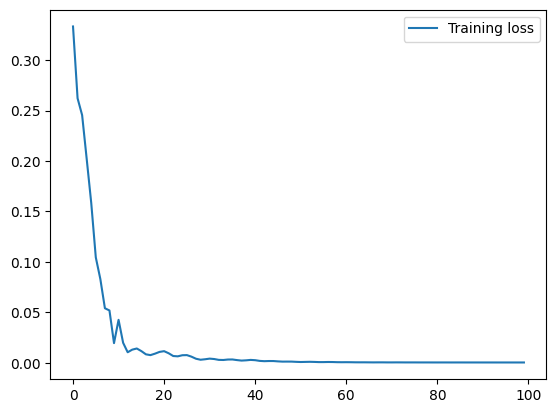

In [22]:
plt.plot(hist, label="Training loss")
plt.legend()
plt.show()

In [23]:
np.shape(y_train_pred)

torch.Size([10781, 1])

In [24]:
# make predictions
y_test_pred = model(x_test)

# invert predictions
y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
y_train = scaler.inverse_transform(y_train.detach().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test.detach().numpy())

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 703.71 RMSE
Test Score: 621.25 RMSE


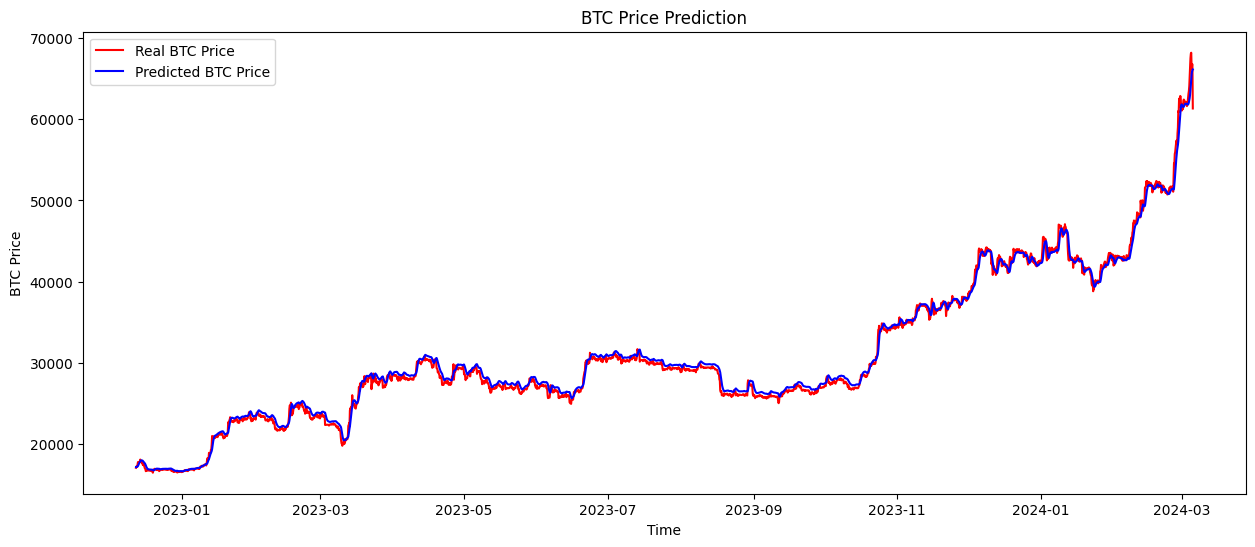

In [25]:
# Visualising the results
figure, axes = plt.subplots(figsize=(15, 6))
axes.xaxis_date()

axes.plot(training_set[len(training_set)-len(y_test):].index, y_test, color = 'red', label = 'Real BTC Price')
axes.plot(training_set[len(training_set)-len(y_test):].index, y_test_pred, color = 'blue', label = 'Predicted BTC Price')
#axes.xticks(np.arange(0,394,50))
plt.title('BTC Price Prediction')
plt.xlabel('Time')
plt.ylabel('BTC Price')
plt.legend()
plt.savefig('btc_pred.png')
plt.show()

Test with most recent data from coinbase

In [168]:
import pickle

In [221]:
btc_4hr_data = pickle.load(open('coinbase_now.pkl','rb'))

In [222]:
btc_4hr_data = btc_4hr_data[['date','close']]

In [223]:
btc_4hr_data

,date,close
0,2024-02-29 12:00:00,62936.22
1,2024-02-29 16:00:00,62790.41
2,2024-02-29 20:00:00,61649.07
3,2024-03-01 00:00:00,61179.03
4,2024-03-01 04:00:00,61111.10
...,...,...
69,2024-03-12 00:00:00,72110.98
70,2024-03-12 04:00:00,71636.99
71,2024-03-12 08:00:00,72153.11
72,2024-03-12 12:00:00,72050.43


In [224]:
# set the dates to datetime
btc_4hr_data.set_index('date',inplace=True)

In [225]:
btc_4hr_data

,close
date,
2024-02-29 12:00:00,62936.22
2024-02-29 16:00:00,62790.41
2024-02-29 20:00:00,61649.07
2024-03-01 00:00:00,61179.03
2024-03-01 04:00:00,61111.10
...,...
2024-03-12 00:00:00,72110.98
2024-03-12 04:00:00,71636.99
2024-03-12 08:00:00,72153.11


In [226]:
scaler = MinMaxScaler(feature_range=(-1, 1))
btc_4hr_data['close'] = scaler.fit_transform(btc_4hr_data['close'].values.reshape(-1,1))

In [227]:
look_back = 60
test_data = btc_4hr_data['close'].values
data = []

# create all possible sequences of length look_back
for index in range(len(test_data) - look_back): 
    data.append(test_data[index: index + look_back])

In [228]:
data = np.array(data)

In [229]:
x_test = data[:,:-1]

In [230]:
x_test = x_test.reshape((14,59,1))

In [231]:
y_test = data[:,-1]
y_test = y_test.reshape(14,1)

In [232]:
# make training and test sets in torch
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)

In [233]:
x_test.shape,y_test.shape

(torch.Size([14, 59, 1]), torch.Size([14, 1]))

In [234]:
# make predictions
y_test_pred = model(x_test)

In [235]:

# invert predictions
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test.detach().numpy())

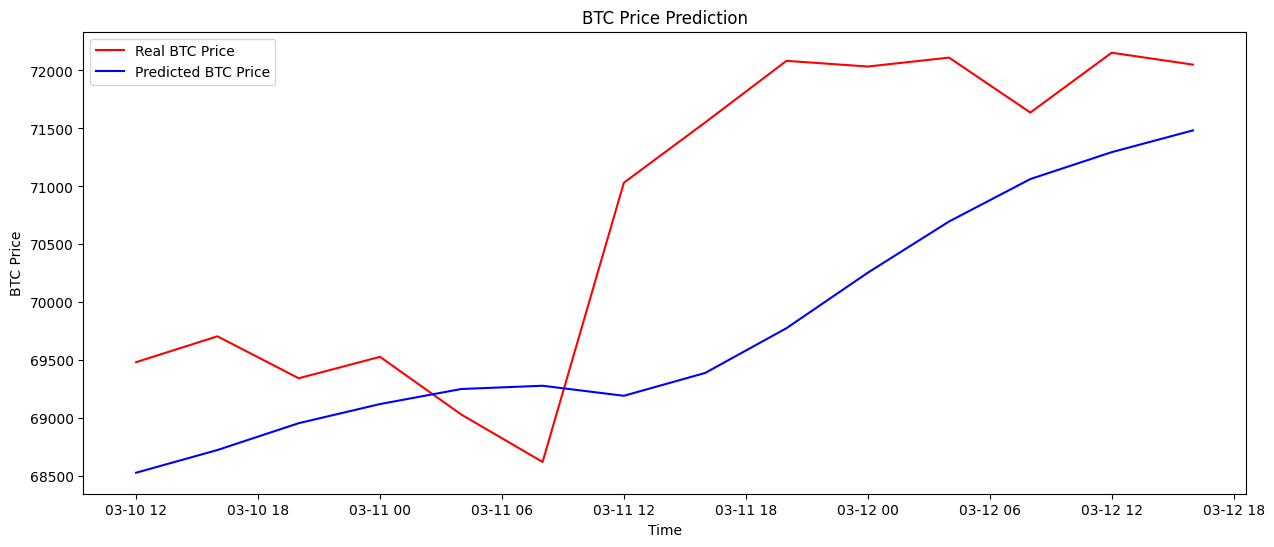

In [236]:
# Visualising the results
figure, axes = plt.subplots(figsize=(15, 6))
axes.xaxis_date()

axes.plot(btc_4hr_data[len(btc_4hr_data)-len(y_test):].index, y_test, color = 'red', label = 'Real BTC Price')
axes.plot(btc_4hr_data[len(btc_4hr_data)-len(y_test):].index, y_test_pred, color = 'blue', label = 'Predicted BTC Price')
#axes.xticks(np.arange(0,394,50))
plt.title('BTC Price Prediction')
plt.xlabel('Time')
plt.ylabel('BTC Price')
plt.legend()
plt.savefig('btc_pred.png')
plt.show()

## 1 HOUR TESTING MODEL

In [13]:
training_set = pd.read_csv('data/crypto/data/formatted/btcusd/btcusd_1_hour_data_formatted.csv')
training_set = training_set[['date','close']]
#training_set = training_set[len(training_set) // 4:]

# set the dates to datetiem
training_set['date'] = pd.to_datetime(training_set['date'])
training_set.set_index('date', inplace=True)

In [14]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

In [15]:
print(f"Using {device} device")

Using cuda device


In [16]:
scaler = MinMaxScaler(feature_range=(-1, 1))
training_set['close'] = scaler.fit_transform(training_set['close'].values.reshape(-1,1))

In [17]:
look_back = 60
x_train, y_train, x_test, y_test = load_data(training_set, look_back)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (43267, 59, 1)
y_train.shape =  (43267, 1)
x_test.shape =  (10817, 59, 1)
y_test.shape =  (10817, 1)


In [18]:
# make training and test sets in torch
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)

In [19]:
y_train.size(),x_train.size()

(torch.Size([43267, 1]), torch.Size([43267, 59, 1]))

In [20]:
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)

loss_fn = torch.nn.MSELoss()

optimiser = torch.optim.Adam(model.parameters(), lr=0.01)
print(model)
print(len(list(model.parameters())))
for i in range(len(list(model.parameters()))):
    print(list(model.parameters())[i].size())

LSTM(
  (lstm): LSTM(1, 32, num_layers=2, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)
10
torch.Size([128, 1])
torch.Size([128, 32])
torch.Size([128])
torch.Size([128])
torch.Size([128, 32])
torch.Size([128, 32])
torch.Size([128])
torch.Size([128])
torch.Size([1, 32])
torch.Size([1])


In [21]:
# Train model
#####################
num_epochs = 100
hist = np.zeros(num_epochs)

# Number of steps to unroll
seq_dim =look_back-1  

for t in range(num_epochs):
    # Initialise hidden state
    # Don't do this if you want your LSTM to be stateful
    #model.hidden = model.init_hidden()
    
    # Forward pass
    y_train_pred = model(x_train)

    loss = loss_fn(y_train_pred, y_train)
    if t % 10 == 0 and t !=0:
        print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    # Zero out gradient, else they will accumulate between epochs
    optimiser.zero_grad()

    # Backward pass
    loss.backward()

    # Update parameters
    optimiser.step()

Epoch  10 MSE:  0.054963368922472
Epoch  20 MSE:  0.016848113387823105
Epoch  30 MSE:  0.0072920373640954494
Epoch  40 MSE:  0.004979188088327646
Epoch  50 MSE:  0.0008246764191426337
Epoch  60 MSE:  0.0005252041155472398
Epoch  70 MSE:  0.00034587178379297256
Epoch  80 MSE:  0.00022986844123806804
Epoch  90 MSE:  0.0001721191656542942


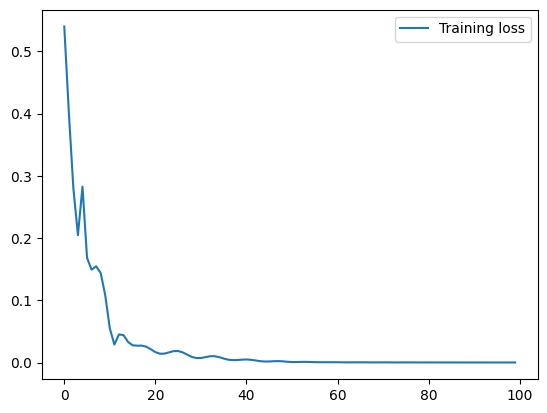

In [22]:
plt.plot(hist, label="Training loss")
plt.legend()
plt.show()

In [24]:
# make predictions
y_test_pred = model(x_test)

# invert predictions
y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
y_train = scaler.inverse_transform(y_train.detach().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test.detach().numpy())

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 405.46 RMSE
Test Score: 394.61 RMSE


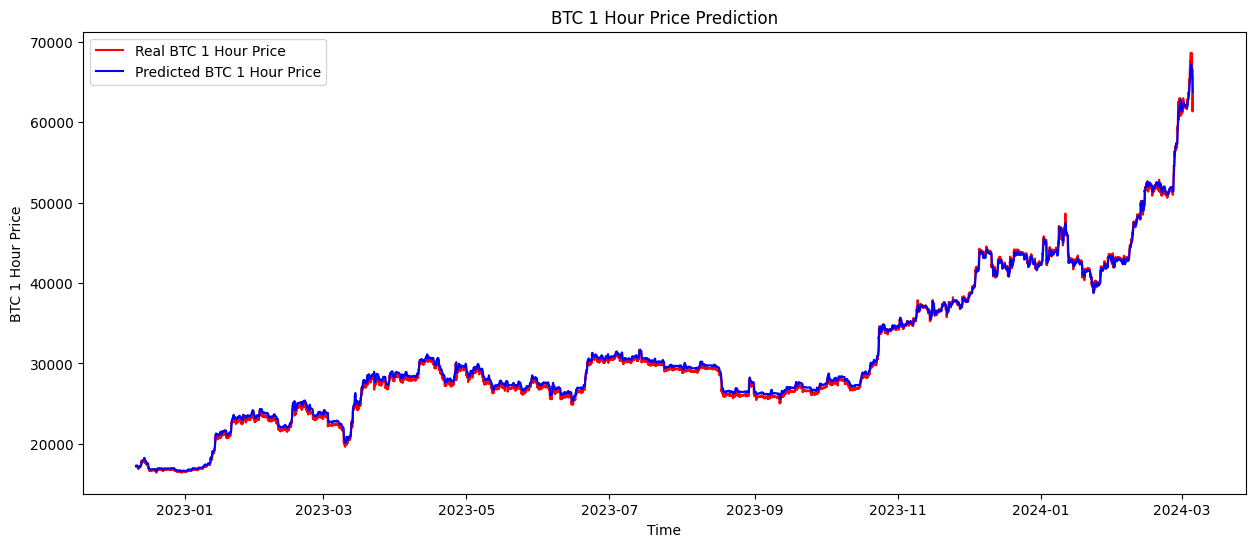

In [25]:
# Visualising the results
figure, axes = plt.subplots(figsize=(15, 6))
axes.xaxis_date()

axes.plot(training_set[len(training_set)-len(y_test):].index, y_test, color = 'red', label = 'Real BTC 1 Hour Price')
axes.plot(training_set[len(training_set)-len(y_test):].index, y_test_pred, color = 'blue', label = 'Predicted BTC 1 Hour Price')
#axes.xticks(np.arange(0,394,50))
plt.title('BTC 1 Hour Price Prediction')
plt.xlabel('Time')
plt.ylabel('BTC 1 Hour Price')
plt.legend()
plt.savefig('btc_pred_1_hour.png')
plt.show()

Test with most recent data from coinbase

In [194]:
import pickle

In [195]:
btc_1hr_data = pickle.load(open('coinbase_now.pkl','rb'))

In [196]:
btc_1hr_data

,date,low,high,open,close,volume
0,2024-02-29 05:00:00,61811.07,62668.98,62454.54,62535.58,934.852081
1,2024-02-29 06:00:00,62470.23,63675.48,62540.78,62995.69,1769.866969
2,2024-02-29 07:00:00,62551.62,63168.34,62995.32,62726.42,1076.768580
3,2024-02-29 08:00:00,62333.00,63151.91,62722.45,62815.14,1121.869378
4,2024-02-29 09:00:00,62277.78,63005.06,62811.98,62695.76,708.449512
...,...,...,...,...,...,...
295,2024-03-12 12:00:00,71462.26,72281.10,72044.26,72199.66,1094.823697
296,2024-03-12 13:00:00,71710.01,72355.41,72198.34,72339.96,1553.069762
297,2024-03-12 14:00:00,71622.36,73027.63,72339.92,71648.97,2819.577086
298,2024-03-12 15:00:00,70852.94,72081.95,71642.31,71711.25,1650.016796


In [197]:
btc_1hr_data = btc_1hr_data[['date','close']]

In [198]:
btc_1hr_data

,date,close
0,2024-02-29 05:00:00,62535.58
1,2024-02-29 06:00:00,62995.69
2,2024-02-29 07:00:00,62726.42
3,2024-02-29 08:00:00,62815.14
4,2024-02-29 09:00:00,62695.76
...,...,...
295,2024-03-12 12:00:00,72199.66
296,2024-03-12 13:00:00,72339.96
297,2024-03-12 14:00:00,71648.97
298,2024-03-12 15:00:00,71711.25


In [199]:
# set the dates to datetime
btc_1hr_data.set_index('date',inplace=True)

In [200]:
scaler = MinMaxScaler(feature_range=(-1, 1))
btc_1hr_data['close'] = scaler.fit_transform(btc_1hr_data['close'].values.reshape(-1,1))

C:\Users\jonat\AppData\Local\Temp\ipykernel_29516\2395733992.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  btc_1hr_data['close'] = scaler.fit_transform(btc_1hr_data['close'].values.reshape(-1,1))


In [202]:
look_back = 60
test_data = btc_1hr_data['close'].values
data = []

# create all possible sequences of length look_back
for index in range(len(test_data) - look_back): 
    data.append(test_data[index: index + look_back])

In [203]:
data = np.array(data)

In [204]:
x_test = data[:,:-1]

In [205]:
x_test = np.expand_dims(x_test, 2)
x_test.shape

(240, 59, 1)

In [206]:
y_test = data[:,-1]
print(y_test)
y_test = np.expand_dims(y_test, 1)
y_test.shape

[-8.07131225e-01 -8.24468546e-01 -7.79133406e-01 -7.65565806e-01
 -8.04429592e-01 -7.99559520e-01 -8.36129210e-01 -7.87803764e-01
 -8.31571583e-01 -8.23848749e-01 -8.23142351e-01 -8.00469687e-01
 -7.86056447e-01 -8.07885170e-01 -8.13621259e-01 -8.57947744e-01
 -8.57487566e-01 -8.38425004e-01 -8.48932677e-01 -8.17530221e-01
 -7.60580265e-01 -7.22813434e-01 -7.72823368e-01 -7.61614392e-01
 -6.46712617e-01 -6.92543594e-01 -6.52710209e-01 -6.64379363e-01
 -6.59653627e-01 -6.49998387e-01 -6.48821623e-01 -5.99536766e-01
 -5.41503439e-01 -5.33142130e-01 -5.01904388e-01 -5.40581386e-01
 -5.11450952e-01 -5.58256623e-01 -5.04132259e-01 -4.36562558e-01
 -2.38071465e-01 -2.30559192e-01 -2.67159447e-01 -2.39925760e-01
 -2.60149804e-01 -2.59149639e-01 -7.27861804e-02 -2.52741114e-02
 -1.21751800e-02  4.41193202e-02  2.22107885e-03  1.44363333e-01
  1.59758059e-01  1.40542670e-01  2.23265971e-01  2.84420354e-01
  2.45312046e-01  3.33418237e-01  2.66921717e-01  2.64437437e-01
  1.19401667e-01  5.18591

(240, 1)

In [207]:
# make training and test sets in torch
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)

In [208]:
x_test.shape,y_test.shape

(torch.Size([240, 59, 1]), torch.Size([240, 1]))

In [209]:
# make predictions
y_test_pred = model(x_test)

In [210]:

# invert predictions
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test.detach().numpy())

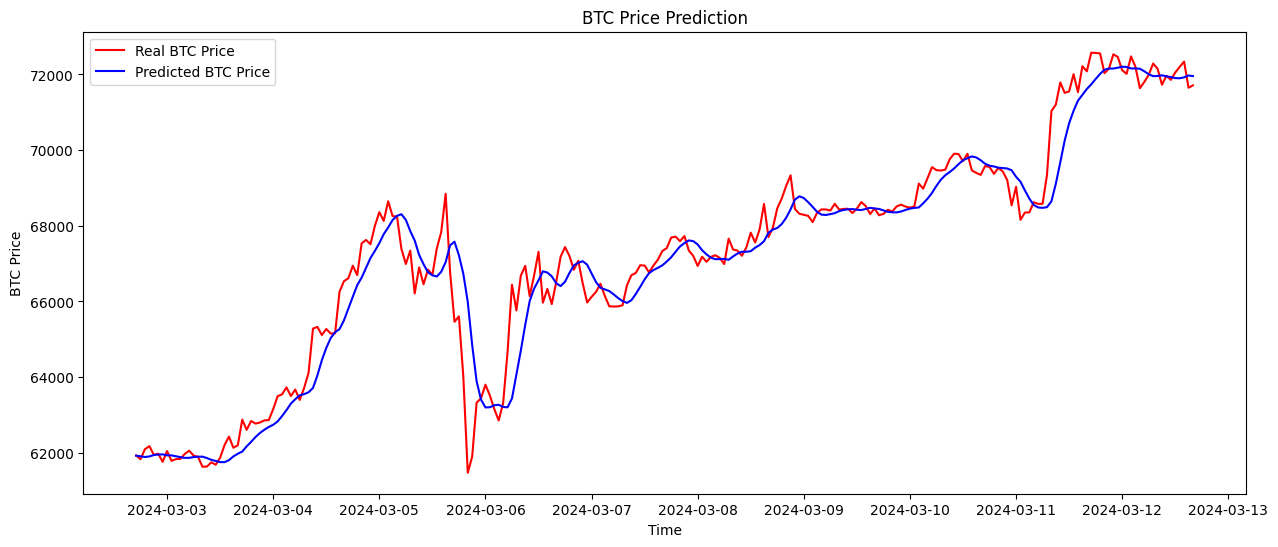

In [213]:
# Visualising the results
figure, axes = plt.subplots(figsize=(15, 6))
axes.xaxis_date()

axes.plot(btc_1hr_data[len(btc_1hr_data)-len(y_test):].index, y_test, color = 'red', label = 'Real BTC Price')
axes.plot(btc_1hr_data[len(btc_1hr_data)-len(y_test):].index, y_test_pred, color = 'blue', label = 'Predicted BTC Price')
#axes.xticks(np.arange(0,394,50))
plt.title('BTC Price Prediction')
plt.xlabel('Time')
plt.ylabel('BTC Price')
plt.legend()
plt.savefig('btc_pred.png')
plt.show()

In [214]:
btc_1hr_data = pickle.load(open('coinbase_now.pkl','rb'))
# set the dates to datetime
btc_1hr_data.set_index('date',inplace=True)

In [215]:
open_price = btc_1hr_data['open'].to_numpy()
open_price = np.expand_dims(open_price,1)
open_price = open_price[59:299]

In [216]:
open_price

array([[61846.5 ],
       [61931.92],
       [61829.92],
       [62096.72],
       [62177.5 ],
       [61947.87],
       [61977.59],
       [61761.07],
       [62045.78],
       [61788.02],
       [61833.51],
       [61837.67],
       [61971.19],
       [62056.08],
       [61927.52],
       [61893.54],
       [61632.71],
       [61634.19],
       [61747.54],
       [61683.5 ],
       [61869.66],
       [62206.1 ],
       [62428.52],
       [62131.6 ],
       [62200.  ],
       [62874.69],
       [62610.77],
       [62839.99],
       [62772.23],
       [62800.46],
       [62857.47],
       [62864.23],
       [63155.74],
       [63487.99],
       [63549.14],
       [63729.45],
       [63502.54],
       [63671.01],
       [63394.9 ],
       [63716.33],
       [64114.41],
       [65283.17],
       [65334.08],
       [65113.33],
       [65266.43],
       [65153.14],
       [65159.03],
       [66256.54],
       [66540.02],
       [66617.16],
       [66951.91],
       [66698.27],
       [6753

In [217]:
pred_diff = open_price - y_test_pred

In [219]:
actual_diff = open_price - y_test

In [220]:
data = np.hstack((pred_diff,actual_diff))
df = pd.DataFrame(data,columns=['pred diff', 'actual_diff'])

In [221]:
df

,pred diff,actual_diff
0,-76.968750,-85.457031
1,22.318437,102.056719
2,-59.271406,-266.919844
3,192.981719,-80.022187
4,236.605469,229.628906
...,...,...
235,-49.471250,-196.119688
236,144.986562,-155.404063
237,275.175937,-141.620938
238,367.005937,690.951250


In [226]:
temp_p, temp_a = 0, 0
row_c = 0
totals_a, totals_p = [], []
for i, row in df.iterrows():
    if row_c >= 4:
        totals_a.append(temp_a)
        totals_p.append(temp_p)
        row_c = 0
    temp_p += row['pred diff']
    temp_a += row['actual_diff']
    row_c += 1

In [237]:
count = 0
for i, row in df.iterrows():
    if (row['pred diff'] > 0 and row['actual_diff'] < 0):
        count+=1

In [238]:
count

82

## Increasing the Layers

In [2]:
import numpy as np
import random
import pandas as pd 
from pylab import mpl, plt

import math, time
import itertools
import datetime
from operator import itemgetter
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
import torch
import torch.nn as nn
from torch.autograd import Variable

In [3]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

In [4]:
print(f"Using {device} device")

Using cuda device


In [6]:
training_set = pd.read_csv('https://raw.githubusercontent.com/juff12/StockTradingModel/main/data/crypto/data/formatted/ethusd/ethusd_1_hour_data_formatted.csv')
training_set = training_set[['date','close']]

# set the dates to datetiem
training_set['date'] = pd.to_datetime(training_set['date'])
training_set.set_index('date', inplace=True)

In [7]:
training_set.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 54144 entries, 2017-12-31 19:00:00 to 2024-03-05 18:00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   close   54144 non-null  float64
dtypes: float64(1)
memory usage: 846.0 KB


In [8]:
training_set.head()

,close
date,
2017-12-31 19:00:00,730.92
2017-12-31 20:00:00,721.62
2017-12-31 21:00:00,730.01
2017-12-31 22:00:00,732.44
2017-12-31 23:00:00,742.59


In [9]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1, 1))
training_set['close'] = scaler.fit_transform(training_set['close'].values.reshape(-1,1))

In [10]:
# function to create train, test data given stock data and sequence length
def load_data(stock, look_back):
    data_raw = stock.values # convert to numpy array
    data = []
    
    # create all possible sequences of length look_back
    for index in range(len(data_raw) - look_back): 
        data.append(data_raw[index: index + look_back])
    
    data = np.array(data)

    test_set_size = int(np.round(0.2*data.shape[0]))
    train_set_size = data.shape[0] - (test_set_size)

    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]

    return [x_train, y_train, x_test, y_test]

In [11]:
look_back = 60
x_train, y_train, x_test, y_test = load_data(training_set, look_back)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (43267, 59, 1)
y_train.shape =  (43267, 1)
x_test.shape =  (10817, 59, 1)
y_test.shape =  (10817, 1)


In [12]:
# make training and test sets in torch
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)

In [13]:
y_train.size(),x_train.size()

(torch.Size([43267, 1]), torch.Size([43267, 59, 1]))

In [14]:
# Build model
#####################
input_dim = 1
hidden_dim = 16
num_layers = 3
output_dim = 1


# Here we define our model as a class
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        # Hidden dimensions
        self.hidden_dim = hidden_dim

        # Number of hidden layers
        self.num_layers = num_layers

        # batch_first=True causes input/output tensors to be of shape
        # (batch_dim, seq_dim, feature_dim)
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)

        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        # Initialize cell state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        # Index hidden state of last time step
        # out.size() --> 100, 32, 100
        # out[:, -1, :] --> 100, 100 --> just want last time step hidden states! 
        out = self.fc(out[:, -1, :]) 
        # out.size() --> 100, 10
        return out

In [15]:
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)

loss_fn = torch.nn.MSELoss()

optimiser = torch.optim.Adam(model.parameters(), lr=0.01)
print(model)
print(len(list(model.parameters())))
for i in range(len(list(model.parameters()))):
    print(list(model.parameters())[i].size())

LSTM(
  (lstm): LSTM(1, 16, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=16, out_features=1, bias=True)
)
14
torch.Size([64, 1])
torch.Size([64, 16])
torch.Size([64])
torch.Size([64])
torch.Size([64, 16])
torch.Size([64, 16])
torch.Size([64])
torch.Size([64])
torch.Size([64, 16])
torch.Size([64, 16])
torch.Size([64])
torch.Size([64])
torch.Size([1, 16])
torch.Size([1])


In [16]:
# Train model
#####################
num_epochs = 100
hist = np.zeros(num_epochs)

# Number of steps to unroll
seq_dim =look_back-1  

for t in range(num_epochs):
    # Initialise hidden state
    # Don't do this if you want your LSTM to be stateful
    #model.hidden = model.init_hidden()
    
    # Forward pass
    y_train_pred = model(x_train)

    loss = loss_fn(y_train_pred, y_train)
    if t % 10 == 0 and t !=0:
        print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    # Zero out gradient, else they will accumulate between epochs
    optimiser.zero_grad()

    # Backward pass
    loss.backward()

    # Update parameters
    optimiser.step()

Epoch  10 MSE:  0.21025387942790985
Epoch  20 MSE:  0.06283639371395111
Epoch  30 MSE:  0.09667114168405533
Epoch  40 MSE:  0.17442375421524048
Epoch  50 MSE:  0.11831073462963104
Epoch  60 MSE:  0.09412864595651627
Epoch  70 MSE:  0.0699043869972229
Epoch  80 MSE:  0.06961352378129959
Epoch  90 MSE:  0.06934806704521179


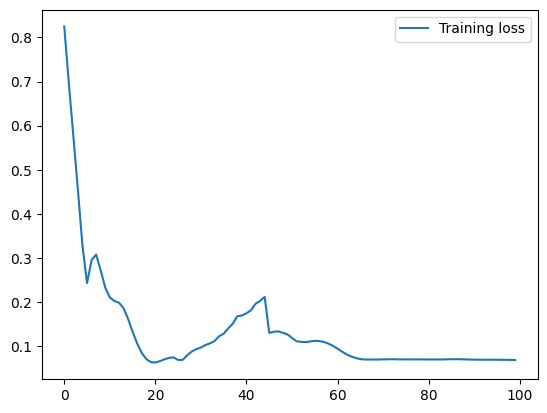

In [17]:
plt.plot(hist, label="Training loss")
plt.legend()
plt.show()

In [18]:
np.shape(y_train_pred)

torch.Size([43267, 1])

In [19]:
# make predictions
y_test_pred = model(x_test)

# invert predictions
y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
y_train = scaler.inverse_transform(y_train.detach().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test.detach().numpy())

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 623.24 RMSE
Test Score: 1133.75 RMSE


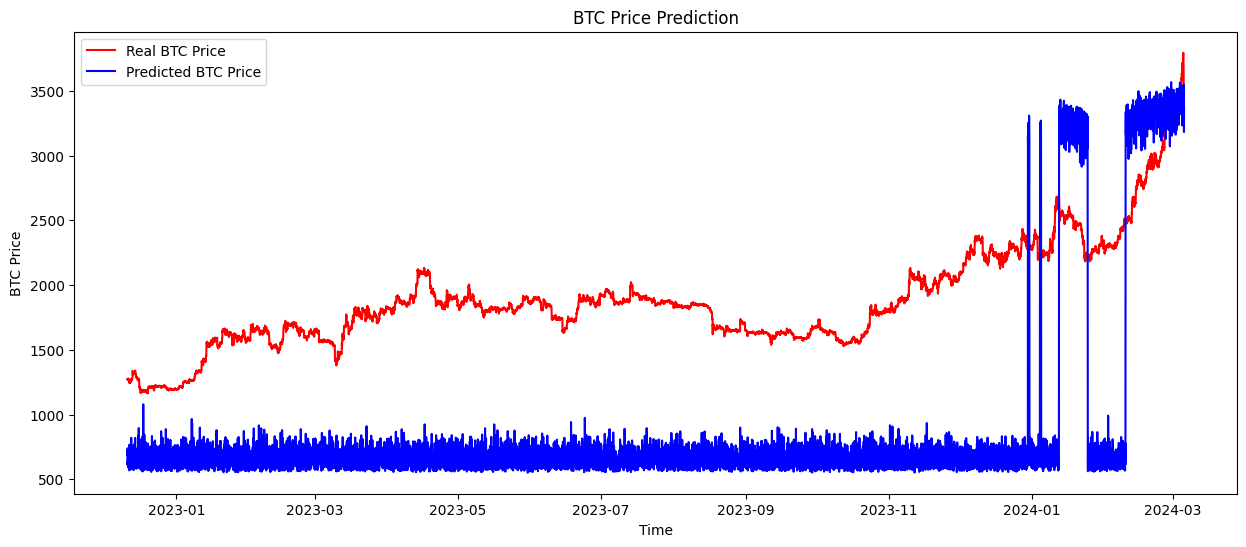

In [20]:
# Visualising the results
figure, axes = plt.subplots(figsize=(15, 6))
axes.xaxis_date()

axes.plot(training_set[len(training_set)-len(y_test):].index, y_test, color = 'red', label = 'Real BTC Price')
axes.plot(training_set[len(training_set)-len(y_test):].index, y_test_pred, color = 'blue', label = 'Predicted BTC Price')
#axes.xticks(np.arange(0,394,50))
plt.title('BTC Price Prediction')
plt.xlabel('Time')
plt.ylabel('BTC Price')
plt.legend()
plt.savefig('btc_pred.png')
plt.show()